понятное [видео](https://www.youtube.com/watch?v=bNb2fEVKeEo) со стенфордского курса, из [материалов](https://cs231n.github.io/convolutional-networks) по которому взяты иллюстрации.

Датасет из [курса](https://github.com/DanAnastasyev/DeepNLP-Course/blob/master/Week%2004/Week_04_Convolutional_Neural_Networks.ipynb) Даниила Анастасьева.

Использовались [материалы](https://github.com/mannefedov/hse_ml_m1/blob/master/7_cnn/cnn.ipynb) из курса Михаила Нефедова.

# Сверточный слой




Желтое - фильтр (= filter,kernel).

Зеленое - входные данные, например, изображение.

Розовое - карта активации (activation map).

Каждый элемент в розовой матрице - результат поэлементного умножения фильтра на числа из области на входных данных.
Обучаемые параметры - элементы фильтра.

![Conv](https://image.ibb.co/e6t8ZK/Convolution.gif)



Чтобы не терять размер матрицы используется паддинг.

![padding](https://3deep.ru/wp-content/uploads/2020/01/keras_conv2d_padding.gif)

from https://3deep.ru/machinelearning/

# Pooling слой  (не обучается)

![Pool](https://cs231n.github.io/assets/cnn/pool.jpeg)
![maxpool](https://cs231n.github.io/assets/cnn/maxpool.jpeg)

# Свертки для текстов устроены немного по-другому. В них на одну размерность меньше.

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png)

From [Character-Aware Neural Language Models](https://arxiv.org/pdf/1508.06615.pdf)

# CNN для обработки текстов



In [1]:
#!pip install torchmetrics

In [2]:
#!pip install ipdb

In [1]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb

### Слова



### Скачивание и подготовка данных

In [2]:
import wget
#wget.download("https://drive.google.com/uc?export=download&id=1z7avv1JiI30V4cmHJGFIfDEs9iE4SHs5")

In [3]:
type_dict = {1:1, -1:0}

In [4]:
positive = pd.read_csv('positive.csv', encoding='utf-8', sep=';', usecols=[3,4], names=['text', 'type'])
negative = pd.read_csv('negative.csv', encoding='utf-8', sep=';', usecols=[3,4], names=['text', 'type'])
data = pd.concat([positive, negative])
data['type'] = [type_dict[i] for i in data['type']]
data.drop_duplicates(inplace=True)

In [5]:
train_data, val_data = train_test_split(data, test_size=0.2, shuffle=True)
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

In [6]:
train_data[train_data.type == 1].shape[0] / train_data.shape[0]

0.5073526030169242

In [7]:
train_data.head(50)

,text,type
0,RT @KamenskiaNastia: наши в падике:* http://t....,1
1,Но средний балл такой же как в прошлой четверт...,0
2,RT @antoninana_: @veselen05 зайчик мой:* http:...,1
3,Фууу.. Я в платье.. Чувствую себя трансвестито...,0
4,RT @do_or_die6: @frannie_kun котану перепадет ...,0
5,Очень много снега сегодня выполо((#москва#снег...,0
6,К Олимпиаде готов( Кружка уже с символикой. #м...,0
7,@FeelDreem ацтань у меня нет новых фоток !!!!!!!(,0
8,"@spoon_kun ну да,если коопом уже играл,то одно...",0
9,@i_sleepwalker_ ахаах мы еще пирамиды построем...,1


Ну что ж... Где-то здесь должен возникнуть препроцессинг, и он возникнет

In [8]:
#!python -m spacy download ru_core_news_sm
import spacy
from tqdm import tqdm
nlp = spacy.load("ru_core_news_sm")

In [9]:
import re
def preprocess(text, nlp):
    #doc = nlp(text)
    #postags_stop = ['ADP', 'AUX', 'CCONJ', 'DET', 'INTJ', 'PART', 'PRON', 'PUNCT', 'SCONJ']
    lemms = []
    doc = re.split('[ \n\t,.]', text)
    #print(doc)
    for word in doc:
        if word:
            lemms.append(word.strip('#,.*\'\"@!?-^$:;').rstrip('():***').lower())
        #lemms.append(word.lemma_.lower())
    return ' '.join(lemms)

In [10]:
preprocess('@GREENloshadka уиии, круто)\nбеларусь, минск\n...	', nlp)

'greenloshadka уиии круто беларусь минск'

Теперь нам нужно попрепроцессить тексты. Или оставить пока так

Почему мы можем трогать только train_data? Потому что иначе может попасть что-нибудь из теста. Вероятно, будет не очень заментно, но исключать возможность не стоит, и на уровне слов она больше, чем на уровне символов

In [11]:
texts_of_lemms = []
vocab = Counter()
for text in tqdm(train_data['text']):
    lemma_text = preprocess(text, nlp)
    vocab.update(lemma_text.split(' '))
    texts_of_lemms = []
print('всего уникальных слов:', len(vocab))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173952/173952 [00:02<00:00, 84121.85it/s]

всего уникальных слов: 290603


In [12]:
vocab

Counter({'rt': 26205,
         'kamenskianastia': 2,
         'наши': 333,
         'в': 43410,
         'падике': 12,
         'http://t': 24605,
         'co/z4h7p7owg4': 1,
         'но': 12243,
         'средний': 19,
         'балл': 25,
         'такой': 1981,
         'же': 7514,
         'как': 16563,
         'прошлой': 41,
         'четверти': 76,
         'а': 27046,
         'оценки': 161,
         'хуже': 332,
         'о_о': 957,
         'antoninana_': 2,
         'veselen05': 1,
         'зайчик': 22,
         'мой': 2543,
         'co/ir0mri1qep': 1,
         'фууу': 44,
         'я': 50084,
         'платье': 194,
         'чувствую': 672,
         'себя': 1748,
         'трансвеститом': 3,
         '': 68930,
         '©дебера': 2,
         'морган': 3,
         'co/c0q8vbr5xm': 1,
         'do_or_die6': 6,
         'frannie_kun': 1,
         'котану': 1,
         'перепадет': 3,
         'немного': 701,
         'бухта': 1,
         'и': 46310,
         'шлюх': 36,


In [13]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных слов, встретившихся больше 5 раз:', len(filtered_vocab))

уникальных слов, встретившихся больше 5 раз: 24287


In [14]:
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for symbol in filtered_vocab:
    word2id[symbol] = len(word2id)

In [15]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [16]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

### Dataset & DataLoader

In [17]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split(' ')
        ids = torch.LongTensor([self.word2id[word.lower()] for word in words if word.lower() in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

### создаем итераторы по данным для трейна и теста

In [18]:
train_dataset = TweetsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=64)

In [19]:
batch = next(iter(train_iterator))

In [20]:
batch[0].shape

torch.Size([64, 20])

In [21]:
[id2word[int(i)] for i in batch[0][0]]

['купила',
 'таких',
 'у',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [22]:
batch[1]

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.]], device='cuda:0')

In [23]:
val_dataset = TweetsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=64)

In [24]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([64, 19])

### CNN model

In [25]:
fm = torch.randn(3, 8, 4) #batch_size, num_filters, seq_len
fm

tensor([[[-0.8585,  0.1068, -0.2031, -0.7439],
         [-1.1823, -0.3482,  0.3343,  0.1933],
         [ 0.1334, -0.5206, -0.4992,  0.0418],
         [-0.0612, -0.7504,  0.0307, -1.0062],
         [ 1.7347,  0.0718, -1.7602,  2.2899],
         [-0.3708,  1.1101, -2.4508, -1.3810],
         [ 1.0157, -0.1978, -2.6794, -1.3508],
         [-0.0808, -0.0658,  0.2489,  0.3255]],

        [[-0.4037,  0.6939, -2.1864,  1.2841],
         [-0.2879, -1.0720,  0.1699,  0.5569],
         [-0.4441,  0.5840, -0.2173,  0.1358],
         [ 1.0915, -0.3356,  0.1033,  0.6081],
         [-1.6265,  1.0804,  0.8635,  0.0212],
         [ 1.1899, -0.1733,  0.0932,  1.1714],
         [ 0.9616, -0.2030,  0.6073, -0.9016],
         [-0.3584, -0.6436, -0.9747,  0.4042]],

        [[ 0.2693,  1.5836, -1.9038,  2.0029],
         [ 1.1331, -0.8760,  0.0552,  2.1501],
         [ 0.5244, -0.7258, -0.6629, -0.7442],
         [-0.2113,  0.1192,  1.5740, -0.0403],
         [-0.9018, -1.8458,  0.1774, -0.0355],
         

In [26]:
mp = torch.nn.MaxPool1d(kernel_size=2, stride=2)
print(mp(fm).shape)
mp(fm)

torch.Size([3, 8, 2])


tensor([[[ 0.1068, -0.2031],
         [-0.3482,  0.3343],
         [ 0.1334,  0.0418],
         [-0.0612,  0.0307],
         [ 1.7347,  2.2899],
         [ 1.1101, -1.3810],
         [ 1.0157, -1.3508],
         [-0.0658,  0.3255]],

        [[ 0.6939,  1.2841],
         [-0.2879,  0.5569],
         [ 0.5840,  0.1358],
         [ 1.0915,  0.6081],
         [ 1.0804,  0.8635],
         [ 1.1899,  1.1714],
         [ 0.9616,  0.6073],
         [-0.3584,  0.4042]],

        [[ 1.5836,  2.0029],
         [ 1.1331,  2.1501],
         [ 0.5244, -0.6629],
         [ 0.1192,  1.5740],
         [-0.9018,  0.1774],
         [-0.5004,  0.9649],
         [-0.0341,  0.8070],
         [ 1.6408,  0.0520]]])

In [27]:
fm.max(2)[0]

tensor([[0.1068, 0.3343, 0.1334, 0.0307, 2.2899, 1.1101, 1.0157, 0.3255],
        [1.2841, 0.5569, 0.5840, 1.0915, 1.0804, 1.1899, 0.9616, 0.4042],
        [2.0029, 2.1501, 0.5244, 1.5740, 0.1774, 0.9649, 0.8070, 1.6408]])

In [28]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.concat_bigrams = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        #self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, text):
        #batch_size x seq_len
        embedded = self.embedding(text)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        #feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        #feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        # batch_size x filter_count3 x seq_len*
        feature_map_trigrams = self.relu(self.trigrams(embedded))

        #pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        #pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        feature_map_concat = self.relu(self.concat_bigrams(concat))
        pooling = feature_map_concat.max(2)[0]
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(pooling)
        logits = self.out(logits)
        
        return logits

In [29]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch)

tensor([[ 3851, 20174, 23586,  ...,     0,     0,     0],
        [ 4264, 23529,  6791,  ...,     0,     0,     0],
        [22083, 19755, 13399,  ...,     0,     0,     0],
        ...,
        [23529, 12999, 17503,  ...,     0,     0,     0],
        [16278,  4264, 17536,  ...,     0,     0,     0],
        [13675,  7667,  5455,  ...,     0,     0,     0]])


In [30]:
print(batch)

tensor([[ 3851, 20174, 23586,  ...,     0,     0,     0],
        [ 4264, 23529,  6791,  ...,     0,     0,     0],
        [22083, 19755, 13399,  ...,     0,     0,     0],
        ...,
        [23529, 12999, 17503,  ...,     0,     0,     0],
        [16278,  4264, 17536,  ...,     0,     0,     0],
        [13675,  7667,  5455,  ...,     0,     0,     0]])


In [31]:
y

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]])

In [32]:
model = CNN(len(id2word), 64)
output = model(batch)
print(output)

tensor([[0.4922],
        [0.4992],
        [0.4954],
        [0.4753],
        [0.5017],
        [0.4539],
        [0.4677],
        [0.4949],
        [0.4889],
        [0.4672],
        [0.4906],
        [0.4952],
        [0.4851],
        [0.4730],
        [0.4895],
        [0.4954],
        [0.4580],
        [0.5007],
        [0.4691],
        [0.4779],
        [0.4976],
        [0.4879],
        [0.4700],
        [0.4889],
        [0.4769],
        [0.4996],
        [0.4794],
        [0.5092],
        [0.4982],
        [0.5193],
        [0.5018],
        [0.4998],
        [0.5022],
        [0.4753],
        [0.4812],
        [0.4544],
        [0.4753],
        [0.4883],
        [0.4915],
        [0.4877],
        [0.4789],
        [0.4958],
        [0.5285],
        [0.4953],
        [0.4476],
        [0.5116],
        [0.5123],
        [0.5132],
        [0.4961],
        [0.4863],
        [0.4785],
        [0.5247],
        [0.5039],
        [0.4885],
        [0.4834],
        [0

C:\Users\veron\Anaconda3\envs\pt1\lib\site-packages\torch\nn\modules\conv.py:297: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:647.)
  return F.conv1d(input, weight, bias, self.stride,


In [33]:
loss = nn.BCELoss()
loss(output, y)

tensor(0.7037, grad_fn=<BinaryCrossEntropyBackward0>)

In [34]:
f1(output, y.long())

tensor(0.1702)

### training loop, логика обучения и валидации

теперь нам нужны функции для обучения и валидации,
каждый вызов функции - одна эпоха обучения 

За одну эпоху нам надо для каждого батча:

-- применить к нему модель, 

-- посчитать значение функции потерь, 

-- посчитать градиенты,

-- обновить веса (параметры модели)


In [35]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [36]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

### инициализируем модель, задаем оптимизатор и функцию потерь

In [55]:
model = CNN(len(word2id), 64)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

### запуск обучения!

In [56]:
%%time
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(5):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.6840740198138895
Train loss: 0.6778654911551057
Train loss: 0.6732063175199658
Train loss: 0.6694078707629115
Train loss: 0.6659779350328903

Evaluating on train...
Val loss: 0.6455902968605506, Val f1: 0.623845100402832
Val loss: 0.6440324456461014, Val f1: 0.6262890696525574
Val loss: 0.6448358531666036, Val f1: 0.6238782405853271
Val loss: 0.6450151067239137, Val f1: 0.6246662139892578
Val loss: 0.6448135678611789, Val f1: 0.6239891648292542

Evaluating on test...
Val loss: 0.6561624332710548, Val f1: 0.6135485172271729
Val loss: 0.6521162423700424, Val f1: 0.6200931072235107
Val loss: 0.6536487080248333, Val f1: 0.6141079664230347
Val loss: 0.6535160311019224, Val f1: 0.6115541458129883
Val loss: 0.6526209271357933, Val f1: 0.6133062243461609

starting Epoch 1
Training...
Train loss: 0.6443344053307143
Train loss: 0.6421200071611712
Train loss: 0.6400454614759956
Train loss: 0.638741843193042
Train loss: 0.6375825553803033

Evaluating on 

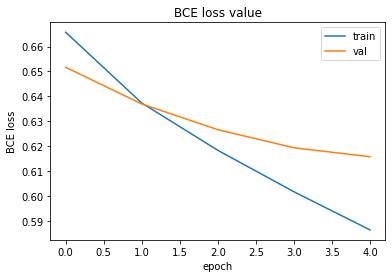

In [57]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

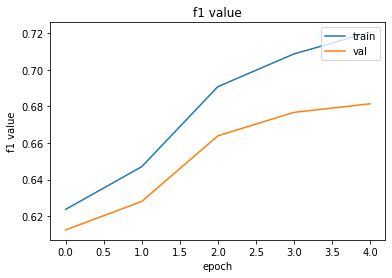

In [58]:
import matplotlib.pyplot as plt
plt.plot([i.cpu() for i in f1s])
plt.plot([i.cpu() for i in f1s_eval])
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [65]:
print('f1 c дропаутом и уменьшением lr и количества эпох')
print(f1s_eval[-1].item())
print('loss c дропаутом и уменьшением lr и количества эпох')
print(losses_eval[-1])

f1 c дропаутом и уменьшением lr и количества эпох
0.6814327836036682
loss c дропаутом и уменьшением lr и количества эпох
0.6158179666189586


Мы поменяли learning rate, количество эпох и добавили дропаут -- кажется, стало чуть лучше

Для анализа ошибок можно посмотреть на те примеры, которые мы (не)правильно предсказываем

In [228]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
                text = ''.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

In [229]:
fp, fn, tp, tn = predict(model, val_iterator)

In [230]:
print('что правильно предсказываем:', tp[:100])

что правильно предсказываем: ['даонионидумаличтомыиправдатакиенасамомтоделевсевсенормально', 'rtнезадаютэтобесплатныйсайтличноотебечтомы', 'rtедуввокругтакая', 'rtпозвонилавыздоравливай', 'недостаточноатемаобъяснилэточтоуменядрузьянепо', 'воченьнебольшойив', 'rtтакидедуанапочтеотдельныйящикраньшетак', 'поздравляювассднемделаюисполнения', 'rtспокойнойванв', 'ятолькохотелутебякактыпопалввсвободныйот', 'ябезумноусталазасегодняшниймоимроднымзаэтотвечер!', 'такбыисъел', 'ещенукакзато', 'какжеячтонекоторыелюдибылинамоемсулыбкой', 'сижуввдетскомтеатре—братдевушкииграетсразу2', 'дачтобктебепришел', 'rtтымнеяведьведусебякактебенравятсятольковтвоём', 'акаквышлидумалисбудетскучноинектонемыглубоко', 'когдабабушказаходитвавтобусвсявнезапно', 'собрал', 'какзафотовинстаграмспасибо', 'ивамтоженастроенияещё', 'завтраквпостель2ссыромичашкачерногочаялучшее', 'кпредыдущемууменяестьдрузьястакчтонаихужепримеремогу', 'rtсднембудешь', 'выкакаявыключаювнавсякиймалоли', 'янекогдатыговоришь//теперь', 'наувиделиу

In [231]:
print('ошибочно не относим к фамилиям:', fn[:100])

ошибочно не относим к фамилиям: ['меняужебеситтвоетупоесвоипринципыпрекратисратьвдушуатоубиратьзатобойбудеттолькотвоя', 'атокаквсечтонужноивточтоне', 'имя17минвкуснаякурица', 'какойсамыйкрутойзачет', 'нельзяживотнымахотелось', 'проспала15чувствуюсебясамымчеловекомна', '', 'ярешилазабитьнамодныесейчассериалыиначаласмотретьссамоготакподнимают', 'почемумолодымлюдямтакненравитсяженскаяобувь', 'rtнуещенеанастроениеуже', 'rtпотокскомпасмузыкойнааоттудачерезнаушникио_о', 'чтоэтозафотографии', 'есликвамсночевкоймногоивамнегдеихвозьмитепобольшеионисаминайдутсебе', 'насамомделеявшокес', 'менясилавзрывэмоций', 'чтояменявсегоипоканечтосигаретуменяпздц', 'утебяочэтоточно!', 'ядавнохотелимнонеполучитсялиачегонео_о', 'телефонненадо?а—ахахахах', 'оооообылоавбылилишь', 'ударвчелюстьзаменяет3часаэтопровмнетаклегче', 'забытьвыбывасхотябы', 'даточно', 'нущитонепросто', 'rtкрасиваялюблюпольшу', 'пиздецменяаааподпеснилюбимойнезряжзачеткаколятут', 'нувсезимниеканикулымнеспасибо', 'смотрюнаэтихдураковиузнаюна

In [232]:
print('ошибочно считаем фамилиями:', fp[:100])

ошибочно считаем фамилиями: ['rtвжопе', 'rtзабылаотметитьмойденьрождения29октября', 'янесигратормозитжутко—компне', 'rtnew–дрочунанее', 'ясебеоченьплохотакчтодавайлучшезавтрапойдемвсегулятьиятебетвой', 'теперьуменяестькрутаячтонемного', 'rtпочемутакойсерый—нравится', 'rtуменянапараллелитакаядевка', 'уменятакбарбиневернули', 'атакчтобывсёхорошо', 'яуедунакогдавырасту', 'rtвеликолепнаясериятолько', 'ятожеургантпро', 'почтине', 'ужемоскваспатьпошла', 'деньсвятоговсечтовсе', 'овоттебяитоприятнеемб', 'мнекупилиподарятеготолько29декабряждать15дней', 'пропустилнаминутунетеперьоколостоятьна', 'нунаучебехотяитыпосленгвсе-такиеще', 'надушемнепоможетивановнаиведроснимиибудет', 'япокастоювочередивбанкевсегдапомогаюотправитьпарунаниодинсотрудникбанкани', 'подарилинедавномненаодномдрнувеселаябылабез', 'сегодняпосмотрелднёмфильмнооченьинтереснаяреальная5из', 'чтокак/где/ненас', 'явообщепитьнадобыломеньше', 'да!какздоровоприйтиви38', 'напередчетыревсестоятвключая', 'толькочтоузналчтосегоднячто-то', 'ч